In [ ]:
# inspired by lazyprogrammer

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import itertools


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix



In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)


batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)

    self.fc = nn.Linear(self.M, self.K)
  


  def forward(self, X):

    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, _ = self.rnn(X, (h0, c0))

    out = self.fc(out[:, -1, :])
    
    
    return out

In [ ]:
model = RNN(28, 128, 2, 10)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").to(device)
print(device)

model

cuda:0


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)


for it in range(n_epochs):

  train_loss = []

  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.view(-1, 28, 28)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, targets)
      
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  train_loss = np.mean(train_loss)
  
  
  test_loss = []

  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 28, 28)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  
  
  test_loss = np.mean(test_loss)

  train_losses[it] = train_loss
  test_losses[it] = test_loss
    
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.5545, Test Loss: 0.1612
Epoch 2/10, Train Loss: 0.1322, Test Loss: 0.0946
Epoch 3/10, Train Loss: 0.0836, Test Loss: 0.0753
Epoch 4/10, Train Loss: 0.0612, Test Loss: 0.0588
Epoch 5/10, Train Loss: 0.0478, Test Loss: 0.0557
Epoch 6/10, Train Loss: 0.0409, Test Loss: 0.0458
Epoch 7/10, Train Loss: 0.0349, Test Loss: 0.0533
Epoch 8/10, Train Loss: 0.0321, Test Loss: 0.0580
Epoch 9/10, Train Loss: 0.0303, Test Loss: 0.0501
Epoch 10/10, Train Loss: 0.0231, Test Loss: 0.0532


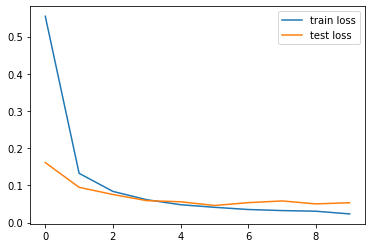

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  inputs = inputs.view(-1, 28, 28)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)
  
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]


train_acc = n_correct / n_total



n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  
  inputs = inputs.view(-1, 28, 28)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)
  
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]


test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9911, Test acc: 0.9850


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


Confusion matrix, without normalization
[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1127    2    2    0    0    0    4    0    0]
 [   2    0 1024    1    2    0    0    2    1    0]
 [   0    0    2  995    0    6    0    5    1    1]
 [   1    0    0    0  951    0    3    4    0   23]
 [   0    0    1    6    0  883    1    0    1    0]
 [  10    2    5    1    9    4  923    0    3    1]
 [   0    1    4    0    0    0    0 1020    0    3]
 [   2    0    0    4    1    4    1    4  953    5]
 [   1    0    0    0    1    6    0    5    0  996]]


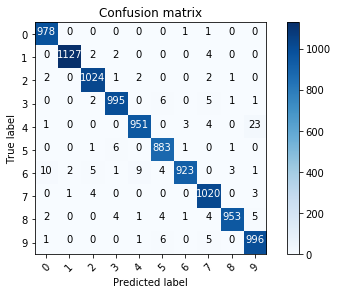

In [ ]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  inputs = inputs.view(-1, 28, 28)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)
  
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))


cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

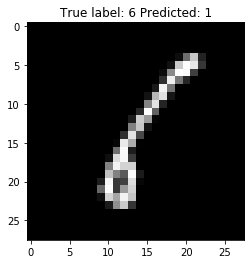

In [ ]:
misclassified_idx = np.where(p_test != y_test)[0]

i = np.random.choice(misclassified_idx)


plt.imshow(x_test[i], cmap='gray')
plt.title(f"True label: {y_test[i]} Predicted: {int(p_test[i])}");